In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)


T = 800 # simulate for 800 ms
dt = 0.1 # ms
points_per_bin = 10      # bins 1 ms wide
sampling_frequency = 1e3 # 1 kHz sampling frequency
burn_in_millis = 200     # the first part of the record to discard (ms)

In [3]:
from quilt.builder import NeuronCatalogue, SpikingNetwork
catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

sn.rescale_populations(1.0)
sn.rescale_connectivity(1)
sn.rescale_weights(1.79)
sn.rescale_delays(1)

poisson_rescale = 1.97

sn.build()

Output()

In [4]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)

## Input/Output

In [5]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

## Run and get spikes

In [7]:
sn.run(dt=dt, time=T)

Running network consisting of 14622 neurons for 8000 timesteps
--------------------------------------------------
**************************************************
Simulation took 11 s	(1.42 ms/step)
	Gathering time avg: 0.023 us/step
	Inject time avg: 116.849 us/step
Population evolution stats:
	0:
		evolution:	363.195 us/step	---	60 ns/step/neuron
		spike emission:	33.4861 us/step	---	5 ns/step/neuron
	1:
		evolution:	351.876 us/step	---	58 ns/step/neuron
		spike emission:	96.5324 us/step	---	16 ns/step/neuron
	2:
		evolution:	73.3051 us/step	---	174 ns/step/neuron
		spike emission:	24.8594 us/step	---	59 ns/step/neuron
	3:
		evolution:	96.2103 us/step	---	123 ns/step/neuron
		spike emission:	27.2425 us/step	---	34 ns/step/neuron
	4:
		evolution:	56.0026 us/step	---	215 ns/step/neuron
		spike emission:	7.66525 us/step	---	29 ns/step/neuron
	5:
		evolution:	65.4879 us/step	---	160 ns/step/neuron
		spike emission:	5.62838 us/step	---	13 ns/step/neuron
	6:
		evolution:	88.9223 us/step	

In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

In [9]:
def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

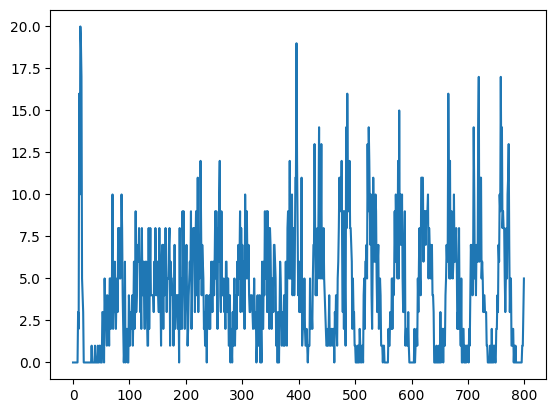

In [10]:
plt.plot(bin_spikes(spikes["D1"]))
plt.show()

In [ ]:
del sn

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [11]:
import optuna

from scipy.signal import welch

optimize_population = "GPeTA"

def build_network(poisson_rescale, rescale_weights):
    
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(1)
    sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn

def beta_power(sn):
    sn.run(dt=0.1, time=T)
    
    spikes = sn.populations[optimize_population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    beta_mask = (f>12)&(f<30)
    
    return np.trapz(PSD[beta_mask], x=f[beta_mask])
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    return beta_power(sn)
    

In [ ]:
set_verbosity(0) # Turns off C++ outputs

study = optuna.create_study(direction = 'maximize')
study.optimize(optimize_beta_power, n_trials = 30, n_jobs = -1, catch=(ValueError, TypeError))

[I 2024-01-19 22:48:06,477] A new study created in memory with name: no-name-adaac4cb-8d24-4e14-8c5d-f04320a8ebe5
[I 2024-01-19 22:49:04,504] Trial 1 finished with value: 0.2687449349871961 and parameters: {'poisson_rescale': 1.9414748363695276, 'weight_rescale': 0.5009952262774722}. Best is trial 1 with value: 0.2687449349871961.
[I 2024-01-19 22:49:15,744] Trial 2 finished with value: 0.17241481912213857 and parameters: {'poisson_rescale': 1.1015268229017319, 'weight_rescale': 1.0877730869001956}. Best is trial 1 with value: 0.2687449349871961.
[I 2024-01-19 22:49:28,530] Trial 6 finished with value: 0.1251584248491873 and parameters: {'poisson_rescale': 1.13255344720891, 'weight_rescale': 1.0645643952090191}. Best is trial 1 with value: 0.2687449349871961.
[I 2024-01-19 22:49:41,243] Trial 7 finished with value: 1.170554711401685 and parameters: {'poisson_rescale': 0.38932371395691945, 'weight_rescale': 0.7136671641468615}. Best is trial 7 with value: 1.170554711401685.
[I 2024-01-1

## Plot best params

In [ ]:
set_verbosity(1)
best_params = study.best_params
print(best_params)
sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
print(beta_power(sn))

In [ ]:
from scipy.integrate import simpson

timesteps_per_bin = 10
sampling_frequency = 1e4/timesteps_per_bin
fig, ax = plt.subplots()

binned_spikes = dict()
for pop in sn.populations:
    spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes[pop] = bin_spikes(spikes)
    binned_spikes[pop] = binned_spikes[pop][200:]
    print(f"Mean fire rate {pop} is {np.mean(binned_spikes[pop])/sn.populations[pop].n_neurons :.1f} Hz")
    f, PSD = welch(binned_spikes[pop], 
                   1000, 
                   nperseg=600, 
                   noverlap=150,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    plt.plot(f, PSD/norm, label=pop)
print(f"F resolution { f[1] - f[0] :.2f} Hz")
# plt.yscale('log')
plt.legend()
plt.ylabel("normalized PSD")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,150)

In [ ]:
for pop in sn.populations:
    plt.plot(binned_spikes[pop]/sn.populations[pop].n_neurons, label=pop)
plt.axhline()
plt.xlabel("Time [ms]")
plt.ylabel("Spiking events per ms per neuron")

## Time signal analysis

In [ ]:
from scipy.signal import butter, sosfiltfilt, freqz


def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data
    
fig, ax = plt.subplots()

pop = "GPeTI"

tt = np.linspace(0, 5, len(binned_spikes[pop]))

plt.plot(tt,binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.legend()